In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
df= pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [3]:
def df_info(df):
    print('\n'+'*'*35)
    print(f'Dataframe Shape : {df.shape}')
    print('\n'+'*'*35)    
    print(f'Count of values for each classes : {df.sentiment.value_counts()}')
    print('\n'+'*'*35)
    print(df.info())
    print('\n'+'*'*35)
    print(df.describe().T)
    print('\n'+'*'*35)
    print(f'Duplicated value counts : {df.duplicated().sum()}')
    
df_info(df)


***********************************
Dataframe Shape : (50000, 2)

***********************************
Count of values for each classes : sentiment
1    25000
0    25000
Name: count, dtype: int64

***********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None

***********************************
             count  mean       std  min  25%  50%  75%  max
sentiment  50000.0   0.5  0.500005  0.0  0.0  0.5  1.0  1.0

***********************************
Duplicated value counts : 418


In [4]:
def find_duplicates(df):

    duplicates = df[df.duplicated(subset=['review'], keep=False)]
    return duplicates

print('*'*65)
duplicates = find_duplicates(df)
print(f'Duplicated reviews: {len(duplicates)}')
print('*'*65)
print(duplicates.sort_values('review').head(10))
print('*'*65)


*****************************************************************
Duplicated reviews: 824
*****************************************************************
                                                  review  sentiment
34058  "Go Fish" garnered Rose Troche rightly or wron...          0
47467  "Go Fish" garnered Rose Troche rightly or wron...          0
29956  "Three" is a seriously dumb shipwreck movie. M...          0
31488  "Three" is a seriously dumb shipwreck movie. M...          0
47527  "Witchery" might just be the most incoherent a...          0
2976   "Witchery" might just be the most incoherent a...          0
7949   'Dead Letter Office' is a low-budget film abou...          0
32260  'Dead Letter Office' is a low-budget film abou...          0
18022  (Spoilers)<br /><br />Oh sure it's based on Mo...          0
22449  (Spoilers)<br /><br />Oh sure it's based on Mo...          0
*****************************************************************


In [5]:
def remove_duplicates(df):
    df_unique = df.drop_duplicates(subset=['review'], keep='first')
    
    return df_unique

df = remove_duplicates(df)
print('The dataset contains {} rows and {} columns after removing duplicates'.format(df.shape[0],df.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


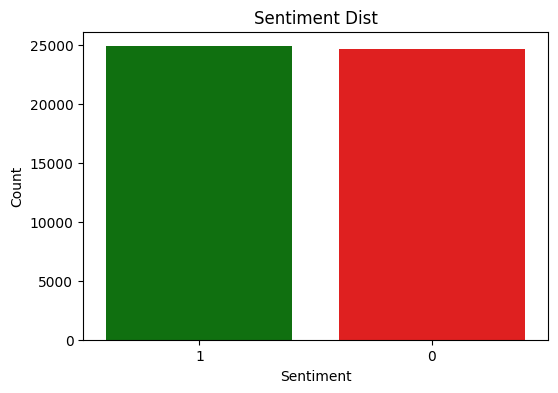

In [6]:
def plot_class_distribution(df):
    plt.figure(figsize = (6,4))
    sns.countplot(x= 'sentiment', data= df,palette = ['green','red'],order = [1,0])
    plt.title('Sentiment Dist')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()
plot_class_distribution(df)

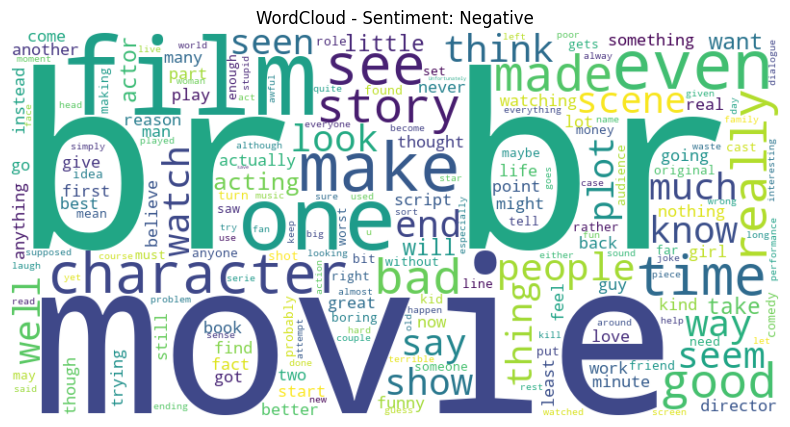

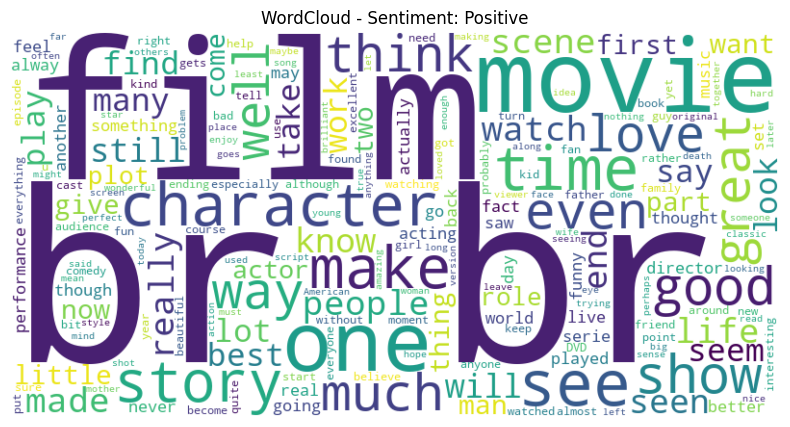

In [7]:
def generate_wordcloud(df, sentiment_value):
    text = " ".join(review for review in df[df['sentiment'] == sentiment_value]['review'])
    wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud - Sentiment: {}'.format('Positive' if sentiment_value == 1 else 'Negative'))
    plt.show()

generate_wordcloud(df, sentiment_value=0)
generate_wordcloud(df, sentiment_value=1)


In [8]:
def clean_text(text):

    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    emoji_pattern = re.compile("[" 
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # other symbols
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r'http\S+', '', text)
    
    text = "".join([char for char in text if char not in string.punctuation])
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['review'] = df['review'].apply(clean_text)

df.head()

/tmp/ipykernel_22/595087163.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


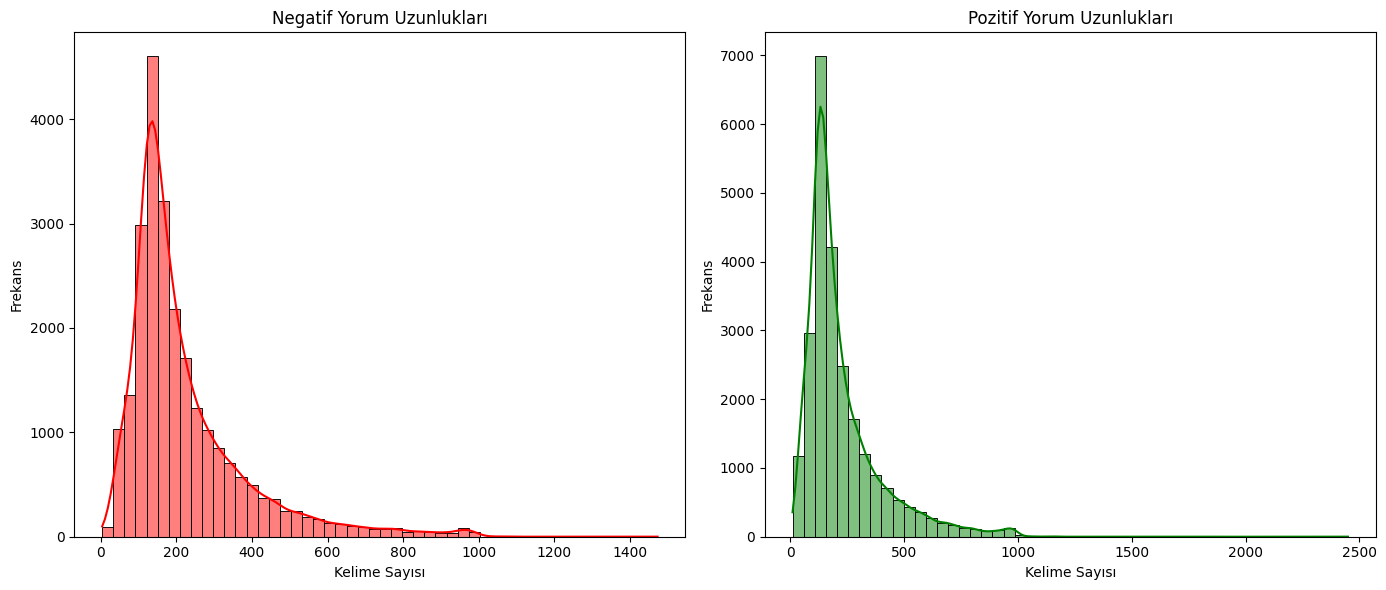

In [9]:

def plot_review_lengths(df):
    # Negatif ve pozitif yorumları ayır
    negative_reviews = df[df['sentiment'] == 0]['review']
    positive_reviews = df[df['sentiment'] == 1]['review']

    # Plot ayarları
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Negatif yorum uzunlukları grafiği (review uzunluğu hesaplanıyor)
    sns.histplot(negative_reviews.apply(lambda x: len(x.split())), bins=50, color='red', kde=True, ax=axs[0])
    axs[0].set_title('Negatif Yorum Uzunlukları')
    axs[0].set_xlabel('Kelime Sayısı')
    axs[0].set_ylabel('Frekans')

    # Pozitif yorum uzunlukları grafiği (review uzunluğu hesaplanıyor)
    sns.histplot(positive_reviews.apply(lambda x: len(x.split())), bins=50, color='green', kde=True, ax=axs[1])
    axs[1].set_title('Pozitif Yorum Uzunlukları')
    axs[1].set_xlabel('Kelime Sayısı')
    axs[1].set_ylabel('Frekans')

    # Grafiklerin gösterimi
    plt.tight_layout()
    plt.show()

# Grafiği çizdir
plot_review_lengths(df)


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sample_text = 'When you were here before, Could not look you in the eye'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Sentence: When you were here before, Could not look you in the eye
   Tokens: ['when', 'you', 'were', 'here', 'before', ',', 'could', 'not', 'look', 'you', 'in', 'the', 'eye']
Token IDs: [2043, 2017, 2020, 2182, 2077, 1010, 2071, 2025, 2298, 2017, 1999, 1996, 3239]


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
print(f"CLS Token (Classification): {tokenizer.cls_token} -> ID: {tokenizer.cls_token_id}  # Used at the beginning of the sequence for classification tasks.")
print(f"SEP Token (Separator): {tokenizer.sep_token} -> ID: {tokenizer.sep_token_id}  # Used to separate sentences or segments.")
print(f"PAD Token (Padding): {tokenizer.pad_token} -> ID: {tokenizer.pad_token_id}  # Used to pad sequences to the same length.")
print(f"UNK Token (Unknown): {tokenizer.unk_token} -> ID: {tokenizer.unk_token_id}  # Used for unknown or out-of-vocabulary tokens.")

CLS Token (Classification): [CLS] -> ID: 101  # Used at the beginning of the sequence for classification tasks.
SEP Token (Separator): [SEP] -> ID: 102  # Used to separate sentences or segments.
PAD Token (Padding): [PAD] -> ID: 0  # Used to pad sequences to the same length.
UNK Token (Unknown): [UNK] -> ID: 100  # Used for unknown or out-of-vocabulary tokens.


In [12]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [13]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2017, 2020, 2182, 2077, 1010, 2071, 2025, 2298, 2017, 1999,
        1996, 3239,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [14]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'you',
 'were',
 'here',
 'before',
 ',',
 'could',
 'not',
 'look',
 'you',
 'in',
 'the',
 'eye',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

/tmp/ipykernel_22/595111119.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'token count')

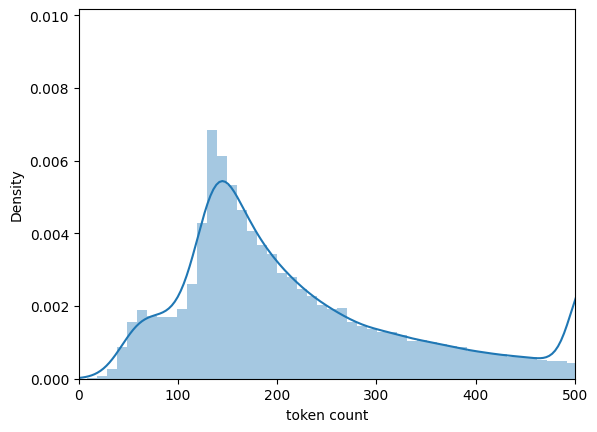

In [16]:
token_lens = []

for txt in df['review']:
    tokens = tokenizer.encode(txt, max_length = 512)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0,500])
plt.xlabel('token count')

In [17]:
MAX_LEN = 200
RANDOM_SEED = 42
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [18]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state= RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [19]:
df_train.shape, df_val.shape, df_test.shape

((44623, 2), (2479, 2), (2480, 2))

In [20]:
train_texts = df_train.iloc[:, 0].tolist()  # The first column contains the texts
train_labels = df_train.iloc[:, 1].tolist()  # The second column contains the labels

val_texts = df_val.iloc[:, 0].tolist()
val_labels = df_val.iloc[:, 1].tolist()

test_texts = df_test.iloc[:, 0].tolist()
test_labels = df_test.iloc[:, 1].tolist()

In [21]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create PyTorch datasets for training, validation, and test data
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, MAX_LEN)


In [22]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [23]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# Initialize the model, optimizer, and scheduler
bert_model_name = 'bert-base-uncased'
num_classes = 2  # Binary classification (positive/negative)
model = BERTClassifier(bert_model_name, num_classes).to(device)

NameError: name 'BertModel' is not defined

In [ ]:
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_epochs = 2  # Define number of training epochs
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_train_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(data_loader)
    return avg_train_loss

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_val_loss += loss.item()
            
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    avg_val_loss = total_val_loss / len(data_loader)
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), avg_val_loss


In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training phase
    avg_train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(avg_train_loss)

    # Validation phase
    accuracy, report, avg_val_loss = evaluate(model, val_dataloader, device)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

In [ ]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=200):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors='pt',
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return "positive" if preds.item() == 1 else "negative"

In [ ]:
test_text = "The movie was great and I really enjoyed the performances of the actors."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(f"Predicted sentiment for test text 1: {sentiment}")

In [ ]:
test_text = "The movie was so bad and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(f"Predicted sentiment for test text 2: {sentiment}")

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def classify_text_by_sentences(text, model, tokenizer, device):
    doc = nlp(text)
    pos_count = 0
    neg_count = 0

    # Yorumdaki her bir cümleyi analiz et
    for sent in doc.sents:
        sentiment = predict_sentiment(sent.text, model, tokenizer, device)
        if sentiment == "positive":
            pos_count += 1
        elif sentiment == "negative":
            neg_count += 1

    # Eğer hem pozitif hem de negatif cümle varsa "mixed" olarak sınıflandır
    if pos_count > 0 and neg_count > 0:
        return "mixed"
    elif pos_count > neg_count:
        return "positive"
    else:
        return "negative"


In [ ]:
text = 'This movie is awesome but I don"t like it ! '
classify_text_by_sentences(text, model, tokenizer, device)